# Project 4 Fletcher 
## Part 2 IDA WordCloud

### Tried Steming, but did not get good results. Create my own stopwords and tune with several test wordcloud. 

### Explored frontier technology news in decades from New York Times API. Applied unsupervised machine learning methods to cluster different topics in tech news and compared the popular fields in time series.


Technology Trend in New York Times: rest API | NLP | LDA | Word2Vec | PCA | Clustering | MongoDB
<br>
• Summarized top topics from frontier technology news in 1945-2017 using New York Times API.
<br>
• Extracted public relationship network of aimed company from mass data.


In [1]:
import pandas as pd
import requests
import numpy as np
import nltk
from time import sleep
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.sklearn
from snownlp import SnowNLP
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import LatentDirichletAllocation
from pymongo import MongoClient
import json
from copy import deepcopy
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction import text 

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/Users/home/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['text']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import pickle
with open('tech1945_2017.plk','rb') as f:
    t=pickle.load(f)

In [3]:
lpdocs_yearly = []
for i in range(1945,2018):
    lpdocs_yearly.append([doc['lead_paragraph'] for doc in t[i] if doc['lead_paragraph']!=None])

In [25]:
len(lpdocs_yearly[-1])

1215

In [2]:
STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves","yesterday","school","board","said","science","scientist","scientific",
    "scientist","scientific","united nations","educational scientific","college",
    "many","today","big","inch",'dr','DR','nov','jan','feb','mar','apr','may','jun',
    'jul','aug','sep','oct','dec','orgnization','invite','shapley','organized','american',
    'international','today','autumn','fall','spring','summer','science',
    'research','scientists','science','appear','giving','church','new','year',
    'purchasing','national','center','continue','committee','acclaimed',
    'study','ignore','tomorrow','welcomed','offices','office','day','james',
    'mr','week','jose','monday','tuesday','wednesday','thursday','friday',
    'saturday','sunday','street','ago','mike','included','include','announced',
    'seniors','annual','service','services','technology','june','picked','york',
    'member','july','united','party','afflicted','9mo','nationwide','yea',
    'sundays','saturdays','korean','mondays','tuesdays','wednesdays','thursdays',
    'fridays','saturdays','sundays'])
#36

In [5]:
def topwords():
    topall = save_top_words(lda, feature_names,20)
    return topall

def print_top_words(model,feature_names,n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()


def save_top_words(model,feature_names,n_top_words):
    top2015=''
    for topic_idx, topic in enumerate(model.components_):
        top2015 += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])+' '
    return top2015

        
def vec_fit_print_topwords(lpyear):
    vectorizer = CountVectorizer(ngram_range=(1,2),stop_words=STOP_WORDS, min_df=1, max_df=0.01)
    x = vectorizer.fit_transform(lpyear)
    doc_vectors = vectorizer.fit_transform(lpyear)
    
    n_topics = 10
    lda = LatentDirichletAllocation(n_topics=n_topics, 
                                max_iter = 50,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state=0)
    lda.fit(doc_vectors)
    
    n_top_words=20
    feature_names = vectorizer.get_feature_names()
    print_top_words(lda, feature_names,n_top_words)
    return save_top_words(lda, feature_names,n_top_words)

In [15]:
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt
import random


def wordcloud_gen(lpdocs):
    leadp =''
    for x in lpdocs:
        leadp=leadp+x.lower()

    leadp = leadp.replace("Science","").replace('Technology','').replace('also','').replace('many','').replace('like','').replace('scientific','').replace('scientist','').replace('said','').replace('one','').replace('company','').replace('will','').replace('Dr','').replace('today','').replace('New','').replace('year','').replace('new','')
    mask = np.array(Image.open("mask4.png"))
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf', stopwords=STOP_WORDS, width=1200,height=800, max_words=100, prefer_horizontal=1,background_color='white', mode = "RGBA",margin=2).generate(leadp)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")

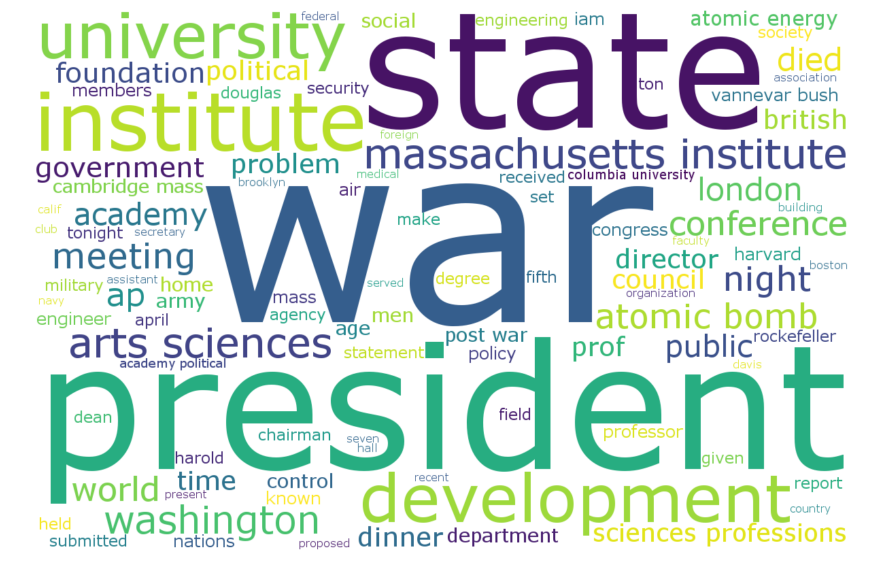

In [16]:
#example wordcloud in 1945
wordcloud_gen(lpdocs_yearly[0])

In [105]:
example2017 = deepcopy(lpdocs_yearly[-1])
example2015 = deepcopy(lpdocs_yearly[-3])
example1947 = deepcopy(lpdocs_yearly[2])
example1945 = deepcopy(lpdocs_yearly[0])
example1952 = deepcopy(lpdocs_yearly[7])

Topic #0:
york announced otto hahn zurich raymond santa succeeding princeton received stockholm sweden plaza 1946 fission swedish otto announced tonight atomic fission nobel prizes company elected outstanding scientists pauli nov 15 1946 zurich switzerland prof wolfgang

Topic #1:
france true new europe paris nov hope seeing churchill addressing rise power incontestable institute foreign 12 winston churchill incontestable place foreign member seeing winston churchill addressing french addressing true rise seeing new hope

Topic #2:
palo expert consultant john expert palo alto st john consultant alto prisoner war understanding human broadway given testimony award served advance revised abreast drama meaning juniors st 15 prof isolated theatre 116th

Topic #3:
parts array text address bewildering array delivered stassen minnesota includes bewildering text follows array parts machine weighs delivered annual political night includes weighs tons automatic calculating minnesota delivered wei

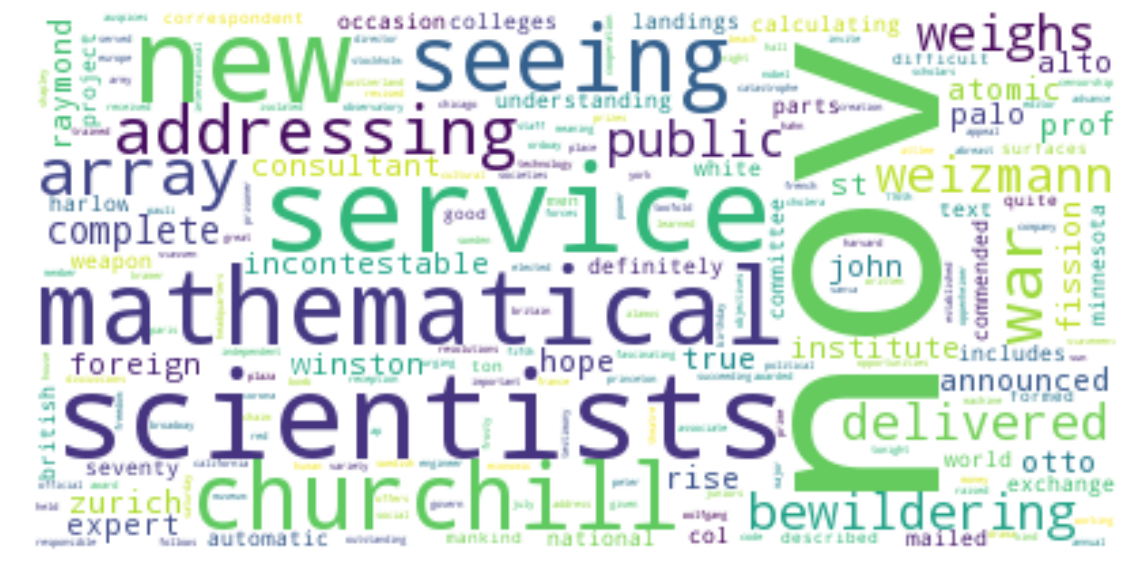

In [88]:
wordcloud_gen(vec_fit_print_topwords(example1945))

In [4]:
# processing data from 1945 to 2017 and save the wordcloud picture in file. 
for i in range(len(lpdocs_yearly)):
    wordcloud_gen(vec_fit_print_topwords(lpdocs_yearly[i]))
    savefig('data/image3/techword'+str(i)+'.png')